# Multi-channel slow-wave detection

This notebook demonstrates how to use YASA to perform **multi-channel slow-waves detection** from a NumPy array (example 1) or a MNE Raw object (example 2). If you haven't done so already, check out the notebook on [single-channel slow-waves detection](05_sw_detection.ipynb).

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

## Example 1: Using NumPy

To illustrate the multi-channel slow-waves detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)

(3, 2161058) ['Cz' 'Fz' 'Pz']


To apply the multi-channel detection, we use the [sw_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html#yasa.spindles_detect) function. Note that we pass the hypnogram and restrain the detection to N3 sleep only.

In [2]:
sw = yasa.sw_detect(data, sf, ch_names=chan, hypno=hypno, include=(3))

# Get the full detection dataframe
sw.summary().round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,1868.43,1868.66,1868.86,1869.09,1869.59,1.16,-104.86,99.64,204.50,1022.49,0.86,3,Cz,0
1,1869.59,1869.84,1870.09,1870.26,1870.46,0.87,-81.60,33.65,115.25,461.00,1.15,3,Cz,0
2,1894.97,1895.20,1895.46,1895.63,1896.03,1.06,-80.39,21.46,101.85,391.74,0.94,3,Cz,0
3,1896.03,1896.23,1896.40,1896.51,1896.60,0.57,-69.74,33.37,103.11,606.54,1.75,3,Cz,0
4,1896.60,1896.80,1896.99,1897.08,1897.16,0.56,-109.20,32.76,141.97,747.18,1.79,3,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6653,15139.35,15139.69,15140.07,15140.45,15140.75,1.40,-71.76,99.55,171.31,450.80,0.71,3,Pz,2
6654,15140.75,15140.99,15141.20,15141.42,15141.65,0.90,-94.10,100.24,194.34,925.41,1.11,3,Pz,2
6655,15141.65,15141.94,15142.20,15142.44,15142.64,0.99,-86.78,124.75,211.53,813.57,1.01,3,Pz,2
6656,15142.64,15142.85,15143.33,15143.62,15143.84,1.20,-114.86,111.03,225.89,470.60,0.83,3,Pz,2


In [3]:
# Get the average per channel and stage
sw.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count    Density  Duration  ValNegPeak  ValPosPeak         PTP  \
Stage Channel                                                                   
3     Cz        2255  25.192012  1.112106  -82.273446   65.193923  147.467369   
      Fz        2183  24.387655  1.107971  -79.893034   60.553331  140.446365   
      Pz        2220  24.801005  1.135482  -81.980608   64.978213  146.958820   

                    Slope  Frequency  
Stage Channel                         
3     Cz       617.477507   0.973076  
      Fz       608.296145   0.976447  
      Pz       595.871965   0.958450

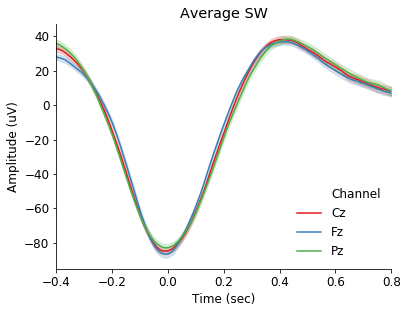

In [4]:
# Plot an average template of the detected slow-waves, centered around the negative peak
ax = sw.plot_average(center="NegPeak", time_before=0.4, time_after=0.8, palette="Set1")
ax.legend(frameon=False)
sns.despine()

*************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the [mne.io.read_raw_fif](https://martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function.

In [5]:
import mne

# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)

In [6]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape = (9, 294000)


In [7]:
# Keep only the channels of interests
raw_eeg = raw.copy().pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw_eeg.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [8]:
# Multi-channel slow-waves detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names.
sw = yasa.sw_detect(raw_eeg)
print(sw.summary().shape[0], 'slow-waves detected.')
sw.summary().round(3)

296 slow-waves detected.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,0.43,0.64,0.83,0.98,1.14,0.71,-58.425,35.605,94.030,494.895,1.408,F3,0
1,13.84,14.06,14.29,14.53,14.79,0.95,-40.706,39.630,80.336,349.288,1.053,F3,0
2,15.23,15.85,16.02,16.22,16.49,1.26,-95.548,116.929,212.478,1249.868,0.794,F3,0
3,38.04,38.23,38.38,38.51,38.62,0.58,-48.818,44.427,93.245,621.633,1.724,F3,0
4,38.62,38.81,38.96,39.14,39.34,0.72,-108.542,116.249,224.791,1498.608,1.389,F3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2843.10,2843.27,2843.49,2843.84,2844.04,0.94,-59.730,55.503,115.234,523.789,1.064,C4,3
292,2844.04,2844.21,2844.35,2844.54,2844.74,0.70,-47.042,63.035,110.077,786.264,1.429,C4,3
293,2844.74,2845.09,2845.33,2845.49,2846.14,1.40,-129.779,57.846,187.625,781.770,0.714,C4,3
294,2846.14,2846.32,2846.65,2846.91,2847.06,0.92,-82.205,23.864,106.069,321.421,1.087,C4,3


In [9]:
sw.summary(grp_chan=True)

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Channel,,,,,,,
C3,54,1.070741,-77.276505,55.799628,133.076133,601.978258,1.016172
C4,53,1.089057,-90.127730,66.911708,157.039438,746.395916,1.005670
F3,105,1.076095,-78.793420,60.738694,139.532114,652.626701,0.997213
F4,84,1.107857,-82.619341,57.851684,140.471025,615.612136,0.986162


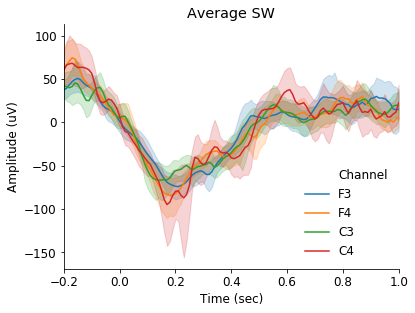

In [10]:
# Plot an average template of the detected slow-waves, centered around the start of the slow-wave
# Definitely noiser than our previous plot since there are fewer detected slow-waves
# in our second datset, because it's a 45 min nap and not a full-night recording!
ax = sw.plot_average(center="Start", time_before=0.2, time_after=1)
ax.legend(frameon=False)
sns.despine()